# Chapter 3: Getting Started with Neural Networks (DLWP Notes)

**Boston Housing Dataset** 

**This example covers a custom K-Fold cross-validation**

In [1]:
import matplotlib.pyplot as plt
import keras
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [4]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

In [7]:
# scale data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## We only have 506 total samples.

### What does this mean for our network architecture?

We'll use a small network with two hidden layers (64 units each).

In [10]:
from keras import models
from keras import layers

# we will be doing this repetitively during k-fold, so build into function
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) # input hidden layer
    model.add(layers.Dense(654, activation='relu')) # hidden layer
    model.add(layers.Dense(1)) # output layer (linear, so not using an activation function)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Custom K-Fold Validation

In [24]:
import numpy as np

k = 4
num_epochs = 500

num_val_samples = len(train_data) // k
all_scores = []
all_mae_histories = []

for i in range(k):
    print('Processing fold #', i)
    
    # break down val, train_data, and train_targets into fold # i
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                         axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                           train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs,
                        validation_data=(val_data, val_targets), batch_size=1, verbose=0, use_multiprocessing=True)
    
    # history now contains validation scores - let's save them so we can access later
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [25]:
avg_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [26]:
all_scores

[2.3591315746307373, 2.2882843017578125, 2.398297071456909, 2.803915500640869]

In [27]:
np.mean(all_scores)

2.462407112121582

## Determine num. epochs to use

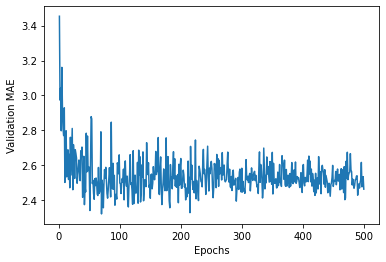

In [31]:
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

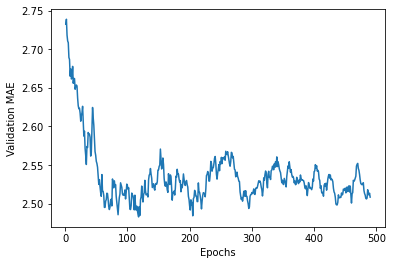

In [35]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(avg_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

MAE starts increasing quickly after 80 - let's use that.



In [36]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 894us/step - loss: 15.6128 - mae: 2.9042


In [37]:
test_mae_score

2.9041638374328613

# Example Takeaways

Here’s what you should take away from this example:


* Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.


* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).


* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.


* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.


* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.